In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import synapseclient as sc
sns.set_style("dark")

%matplotlib inline

In [2]:
syn = sc.login()

Welcome, aryton tediarjo!



In [6]:
entity = syn.get("syn21046180")
data   = pd.read_csv(entity["path"], index_col = 0)

# Barplot on case matched data in mpowerV1

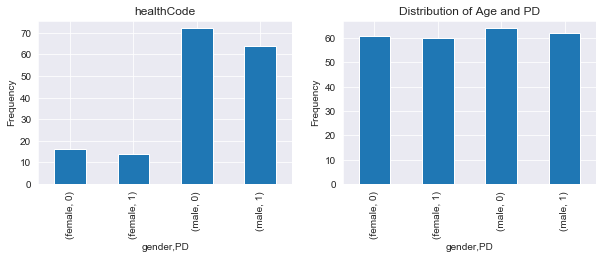

In [7]:
grouped = data.groupby(["gender", "PD"]).agg({"healthCode": lambda x: x.nunique(), "age": np.median})

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,3))


grouped["healthCode"].plot(kind = "bar", ax = axes[0],subplots=True, grid = True, figsize = (15,10))
plt.title("Distribution of Genders and PD")
axes[0].set_ylabel("Frequency")
grouped["age"].plot(kind = "bar", ax = axes[1],subplots=True, grid = True, figsize=(15,10))
plt.title("Distribution of Age and PD")
plt.ylabel("Frequency")


plt.show()

In [23]:
def plot_age_distribution(data):
    male_PD = data[(data["PD"] == 1) & (data["gender"] == "male")]["age"]
    male_NONPD = data[(data["PD"] == 0) & (data["gender"] == "male")]["age"]
    female_PD = data[(data["PD"] == 1) & (data["gender"] == "female")]["age"]
    female_NONPD = data[(data["PD"] == 0) & (data["gender"] == "female")]["age"]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    sns.distplot(male_PD, label = "PD", kde_kws={"shade": True}, hist = False, ax = axes[0])
    sns.distplot(male_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = False, ax = axes[0])
    sns.distplot(female_PD, label = "PD", kde_kws={"shade": True}, hist = False, ax = axes[1])
    sns.distplot(female_NONPD, label = "NONPD", kde_kws={"shade": True}, hist = False, ax = axes[1])
    axes[0].grid()
    axes[0].set_title("Male Distribution")
    axes[1].grid()
    axes[1].set_title("Female Distribution")
    plt.legend()
    plt.show()

In [26]:
PD    = data[data["PD"] == 1]
NONPD = data[data["PD"] == 1]

,recordId,healthCode,phoneInfo,createdOn,x.no_of_steps,x.gait_step_regularity,x.gait_stride_regularity,x.gait_symmetry,x.frequency_of_peaks,x.max_freeze_index,...,AA.gait_step_regularity,AA.gait_stride_regularity,AA.gait_symmetry,AA.frequency_of_peaks,AA.max_freeze_index,AA.freeze_occurences,AA.speed_of_gait,PD,gender,age
0,674ab7db-c410-466b-9799-a1b9068224c8,1e0888df-7059-4fab-9dd7-b0b6616442e6,iPhone 6 Plus,2015-03-09 19:50:29,21.0,0.810516,0.942387,0.131872,122.112890,5.137270,...,0.923291,1.000000,0.076709,569.199744,3.040462,2.0,0.207964,1,male,51
1,7b556fcc-ebb8-46c3-b06a-0723243fc601,1e0888df-7059-4fab-9dd7-b0b6616442e6,iPhone 6 Plus,2015-03-09 19:52:14,19.0,0.820274,0.944324,0.124050,69.909363,2.736828,...,0.905729,1.000000,0.094271,140.449073,0.973890,0.0,0.288430,1,male,51
2,c32e3c41-1f5e-4b4f-9a5f-5f053ddd60ac,1e0888df-7059-4fab-9dd7-b0b6616442e6,iPhone 6 Plus,2015-03-09 19:54:01,19.0,0.795536,0.937513,0.141977,86.828657,3.386095,...,0.930669,1.000000,0.069331,70.535398,34.785969,18.0,0.244246,1,male,51
3,afdaa432-9596-44fc-aaff-639c2701a9c2,1e0888df-7059-4fab-9dd7-b0b6616442e6,iPhone 6 Plus,2015-03-10 15:00:48,21.0,0.957474,0.957474,0.000000,48.784024,5.582943,...,0.919192,1.000000,0.080808,77.625979,0.904931,0.0,0.244879,1,male,51
4,ab47492f-a8c8-4ee4-bf29-d18ea02608ad,1e0888df-7059-4fab-9dd7-b0b6616442e6,iPhone 6 Plus,2015-03-10 15:02:16,18.0,0.933899,0.933899,0.000000,138.149143,4.001124,...,0.745541,0.904861,0.159320,152.521748,0.799969,0.0,0.280797,1,male,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7713,7b77707c-7ad7-4418-8a17-05a1d54ce266,b4bb8c67-33ac-4333-b1aa-6b79babc40fc,iPhone 6,2015-04-19 23:02:21,13.0,0.958741,0.958741,0.000000,36.556155,3.903735,...,0.917141,1.000000,0.082859,78.004790,1.279067,0.0,0.225307,1,male,61
7714,b5481eb7-26d6-4331-a411-bec75780aec1,b4bb8c67-33ac-4333-b1aa-6b79babc40fc,iPhone 6,2015-04-20 12:29:36,15.0,0.988628,0.988628,0.000000,221.042345,0.494592,...,0.899484,1.000000,0.100516,26.920995,2.970790,6.0,0.203367,1,male,61
7715,d81ed4ee-992a-4cff-8a24-c2bbf40043d1,b4bb8c67-33ac-4333-b1aa-6b79babc40fc,iPhone 6,2015-04-20 17:05:57,16.0,0.876888,0.965094,0.088206,30.745736,4.530854,...,0.924793,1.000000,0.075207,24.351132,1.413699,0.0,0.197258,1,male,61
7716,17489ac1-ec80-4c81-b620-c8591934c974,b4bb8c67-33ac-4333-b1aa-6b79babc40fc,iPhone 6,2015-04-20 22:08:44,11.0,0.955485,0.955485,0.000000,31.870981,4.021259,...,0.919797,1.000000,0.080203,901.158500,0.852414,0.0,0.170884,1,male,61


In [1]:
def aggregate_func(data, gender):
    if gender != "all":
        data = data[data["gender"] == gender]
    median_data = data.groupby("healthCode").median()
    mean_data = data.groupby("healthCode").mean()
    max_data = data.groupby("healthCode").max()
    min_data = data.groupby("healthCode").min()
    return median_data, mean_data, max_data, min_data

def plot_distribution(data):
    for i in [i for i in data.columns if ("x" in i) or ("y" in i) or ("z" in i)]:
        PD = data[data["PD"] == True][i].dropna()
        NONPD = data[data["PD"] == False][i].dropna()
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
        sns.distplot(PD, label = "PD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(NONPD, label = "NONPD", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.boxplot(x = "PD", y = i, data = data, ax = axes[1], orient = "v", order = [True, False])
        axes[0].set_title("p-values: {}".format(ttest_ind(PD, NONPD)[1]))
        axes[0].grid()
        axes[1].grid()
        plt.show()
        
def rename_column_name(data,collapse_type):
    for feature in filter(lambda feature: ("x" in feature) 
                          or ("y" in feature) or ("z" in feature) 
                          or ("AA" in feature), data.columns): 
        data  = data.rename({feature: "{}_{}"\
                            .format(collapse_type, feature)}, axis = 1)
    return data

# Check Distributions between max collapsed features

In [15]:
max_data = data.groupby("healthCode").max()
max_data = rename_column_name(max_data, "max")

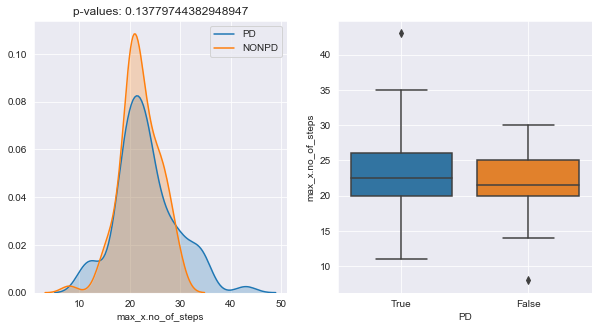

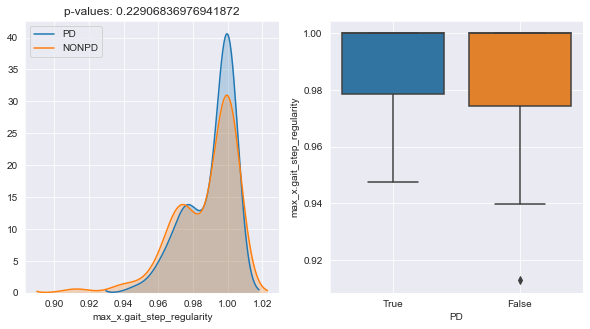

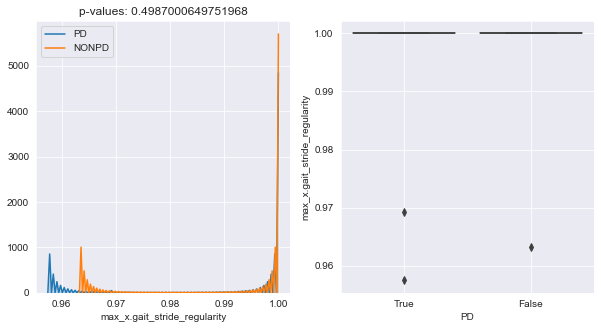

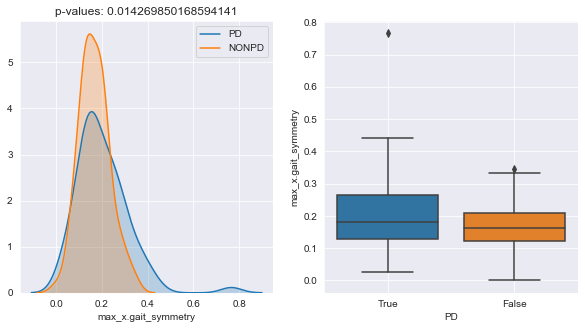

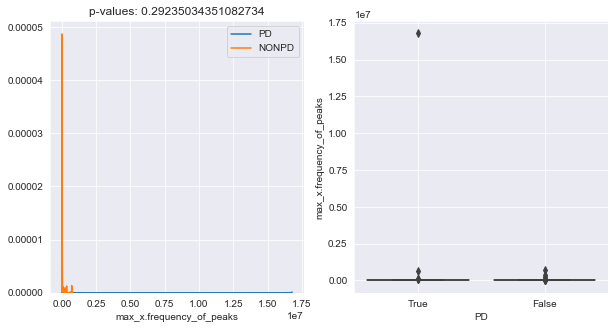

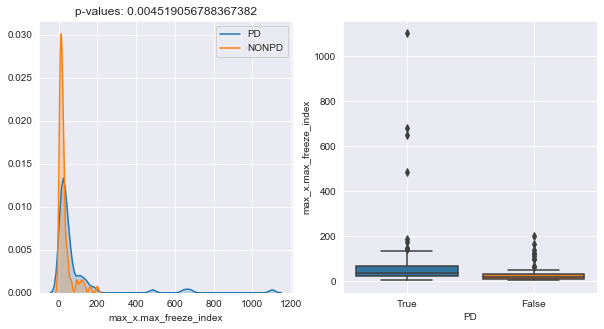

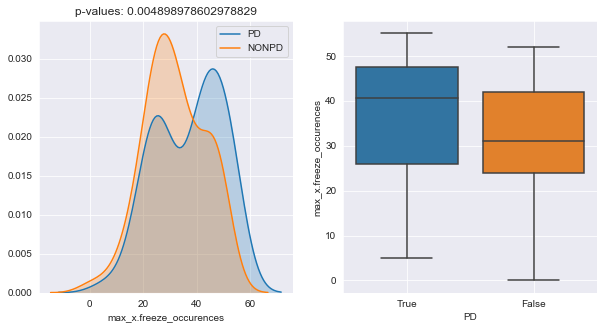

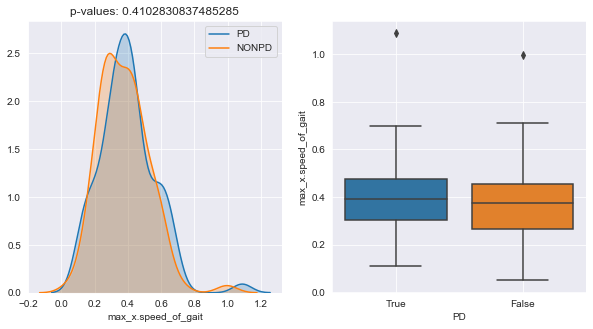

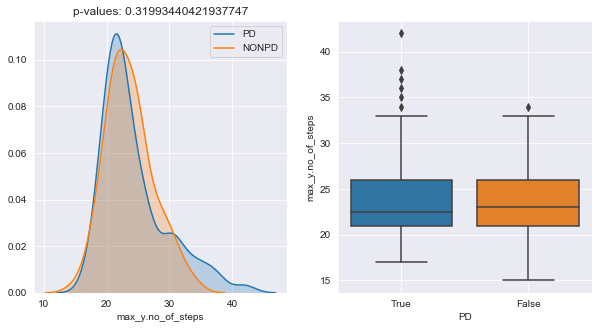

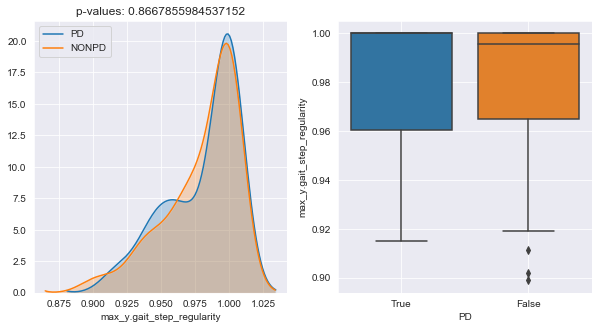

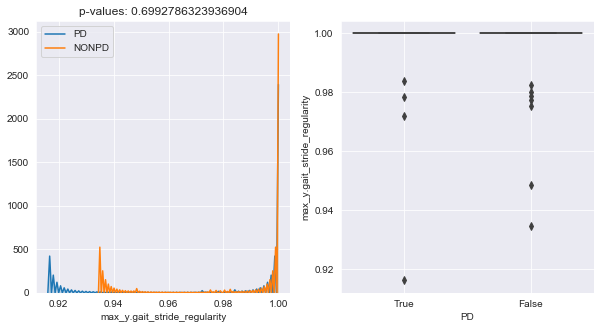

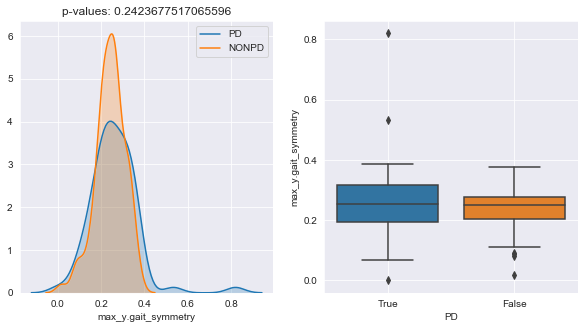

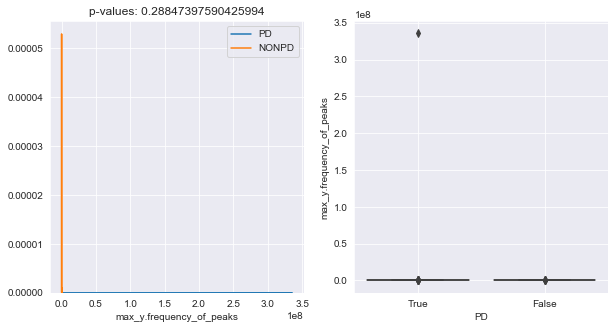

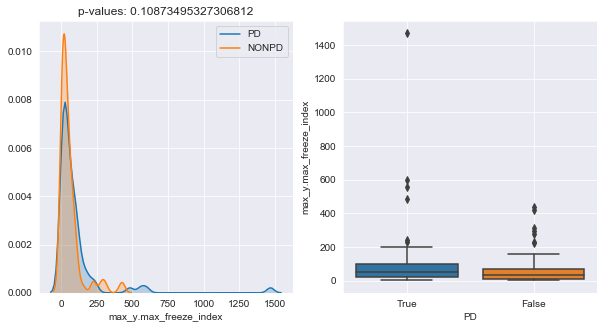

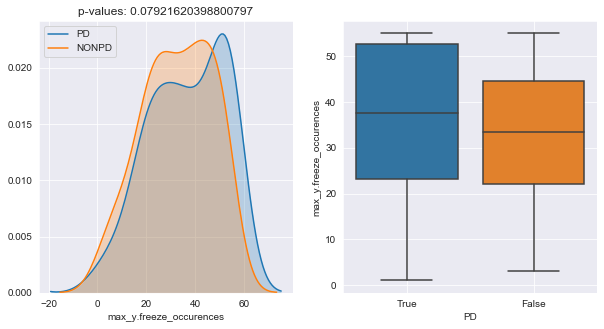

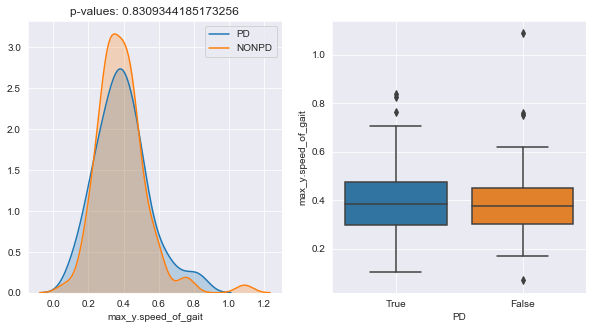

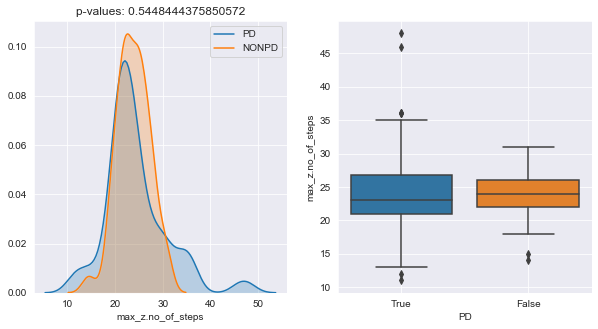

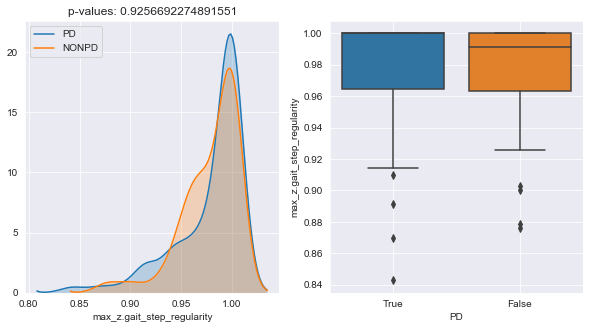

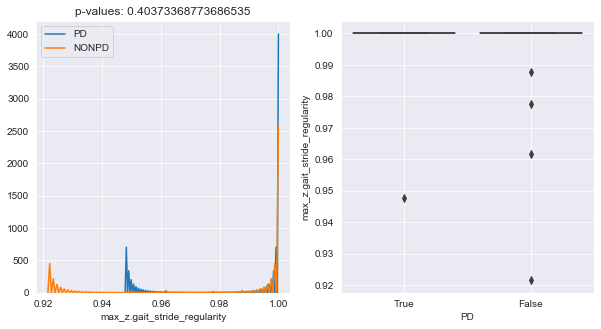

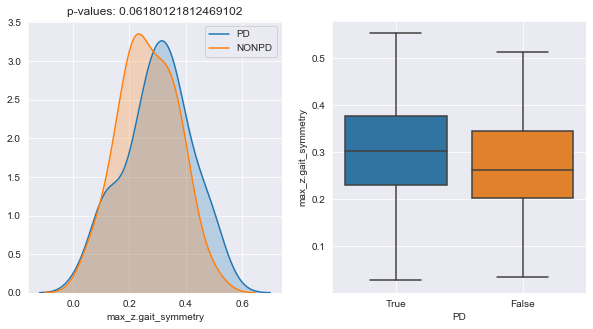

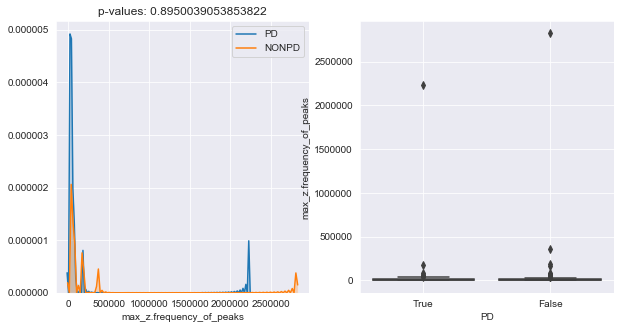

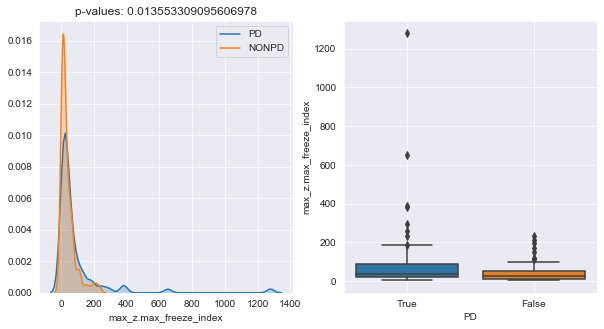

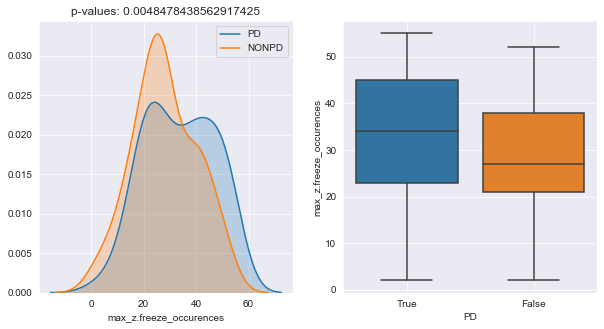

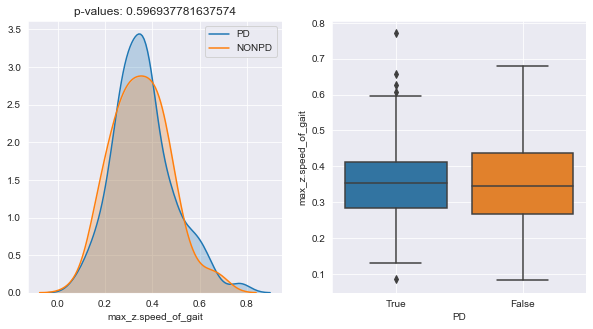

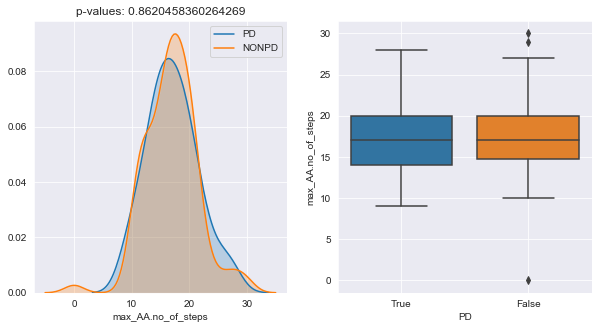

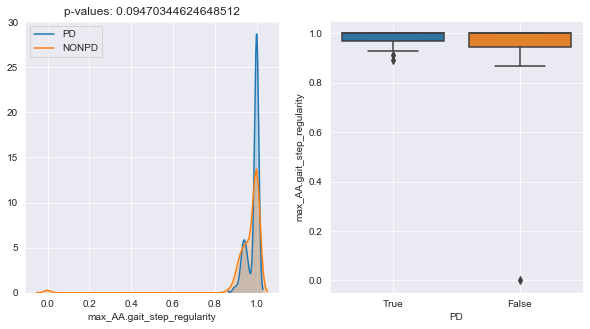

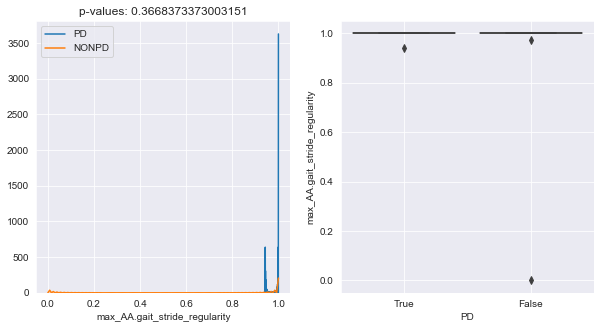

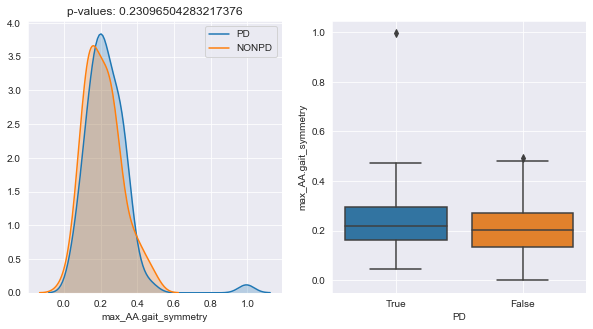

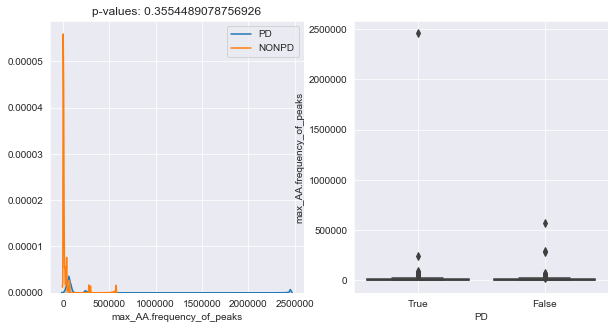

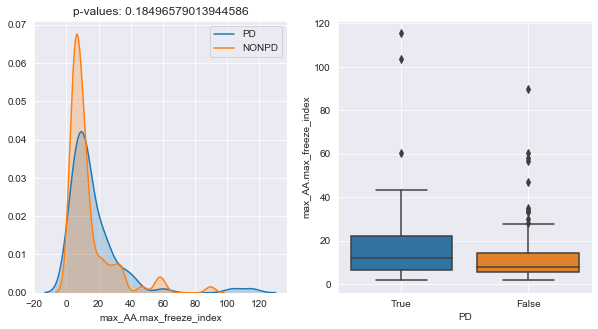

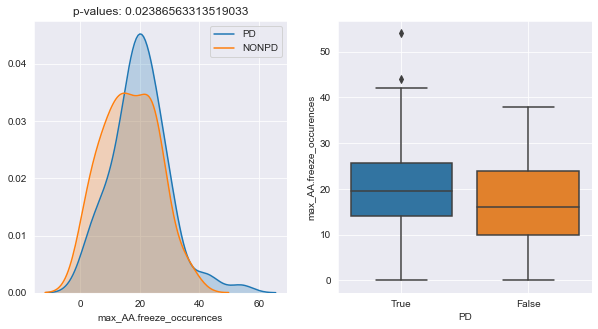

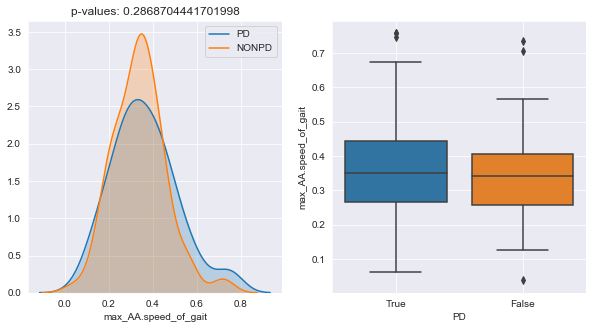

In [16]:
plot_distribution(max_data)

# Select K Best Features

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

In [18]:
walking_train = max_data.copy()
walking_X_train, walking_X_test, walking_y_train, walking_y_test = \
train_test_split(walking_train.drop(["createdOn", \
                                     "phoneInfo", "recordId", "PD", "gender", "age"], axis = 1), 
                 walking_train["PD"], test_size=0.20, random_state = 100)

In [19]:
selector = SelectKBest(chi2, k=15).fit(walking_X_train, walking_y_train)
pd.Series(data = selector.scores_, index = walking_X_train.columns).sort_values(ascending = False)

max_y.frequency_of_peaks         3.442899e+08
max_x.frequency_of_peaks         1.370186e+07
max_AA.frequency_of_peaks        8.345348e+05
max_z.frequency_of_peaks         4.602456e+04
max_x.max_freeze_index           1.208810e+03
max_z.max_freeze_index           8.897928e+02
max_y.max_freeze_index           3.391854e+02
max_x.freeze_occurences          4.986737e+01
max_z.freeze_occurences          3.421301e+01
max_y.freeze_occurences          1.917437e+01
max_AA.freeze_occurences         1.778391e+01
max_AA.max_freeze_index          1.230553e+01
max_x.no_of_steps                2.433806e+00
max_y.no_of_steps                5.537818e-01
max_z.no_of_steps                3.679252e-01
max_z.gait_symmetry              2.055553e-01
max_AA.gait_symmetry             2.006137e-01
max_x.gait_symmetry              1.537460e-01
max_AA.speed_of_gait             1.242865e-01
max_x.speed_of_gait              1.034563e-01
max_y.gait_symmetry              7.522150e-02
max_z.speed_of_gait              5

## Distribution After Splitting

In [20]:
train = walking_X_train.copy()
train["PD"]  = walking_y_train

In [21]:
test = walking_X_test.copy()
test["PD"]  = walking_y_test

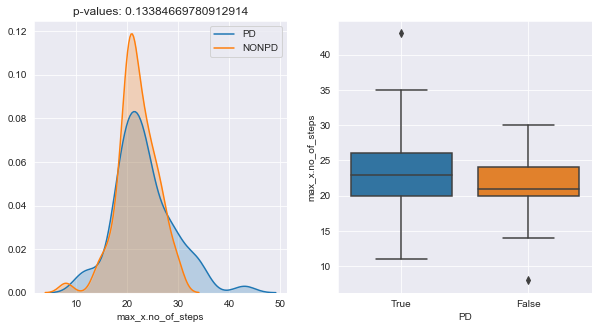

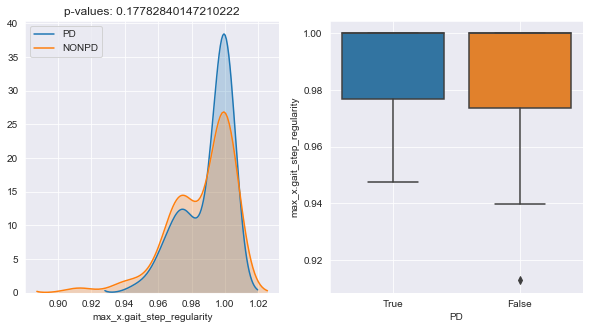

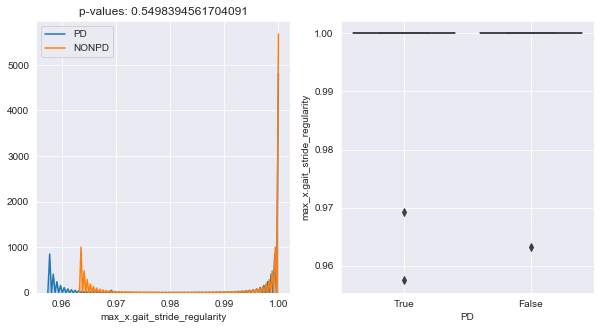

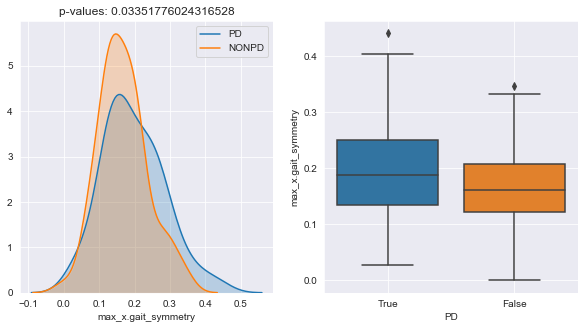

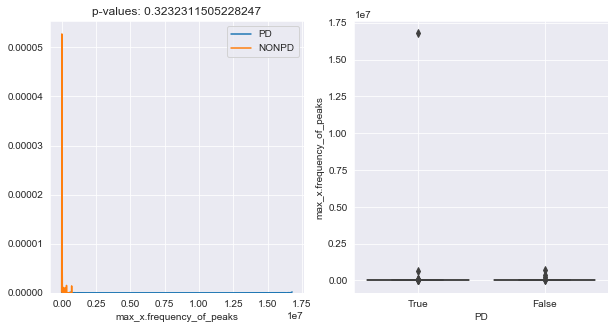

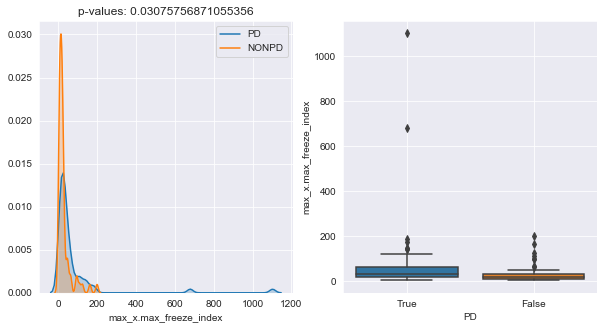

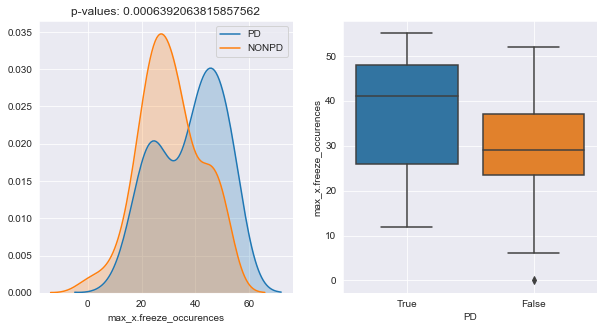

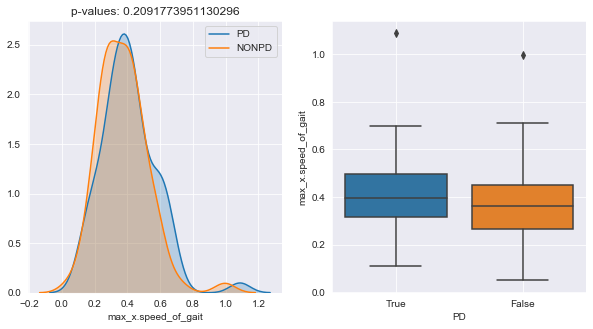

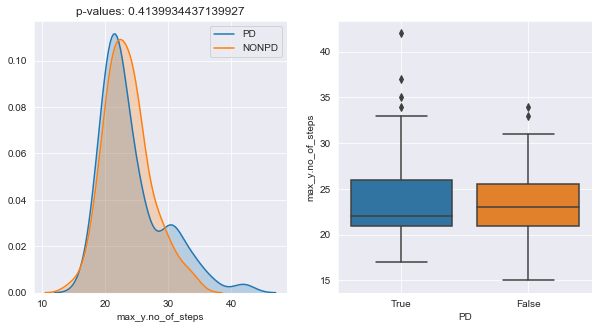

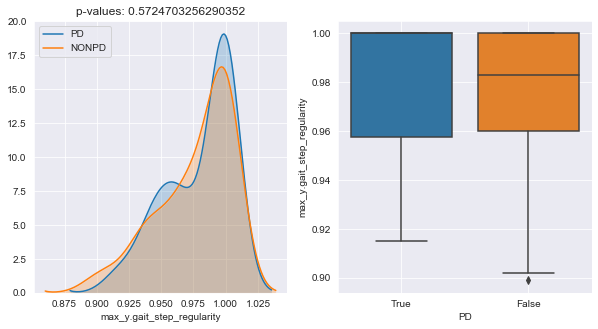

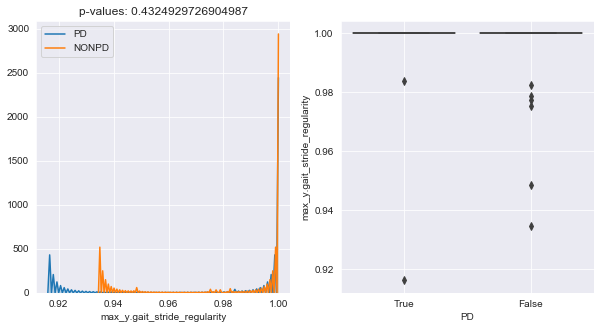

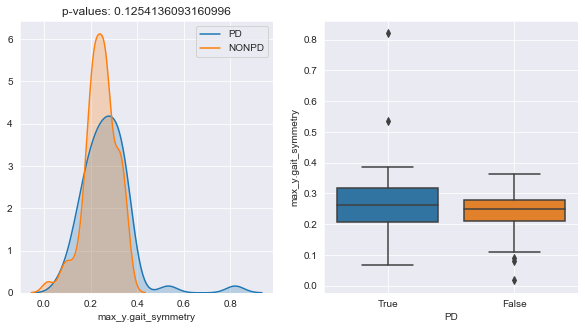

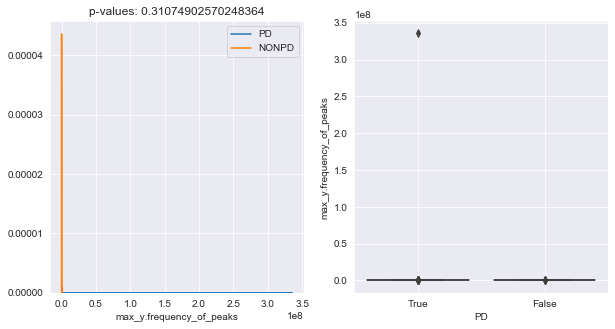

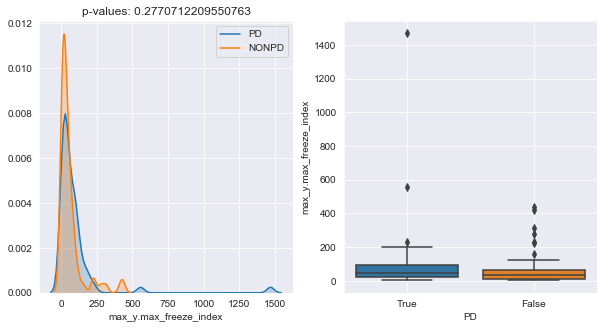

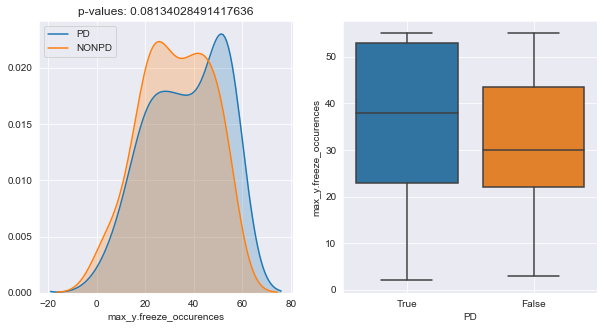

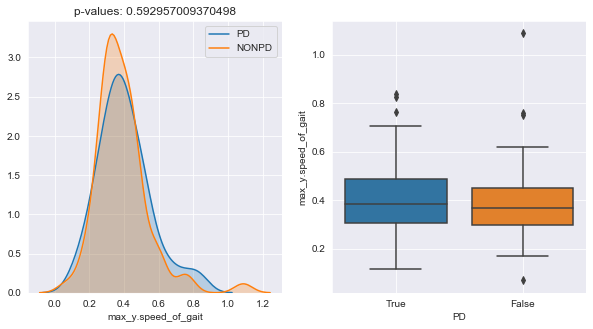

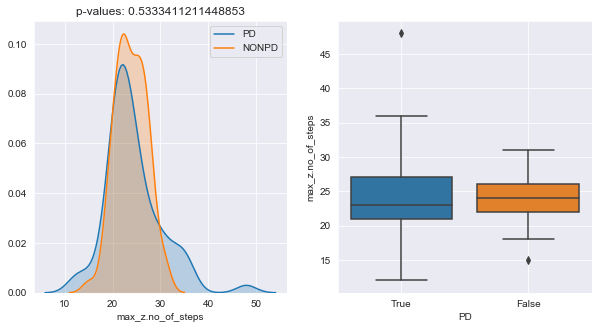

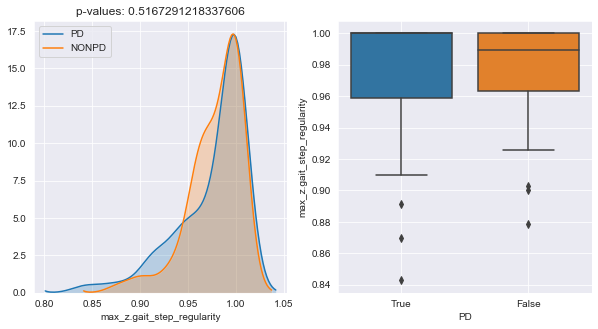

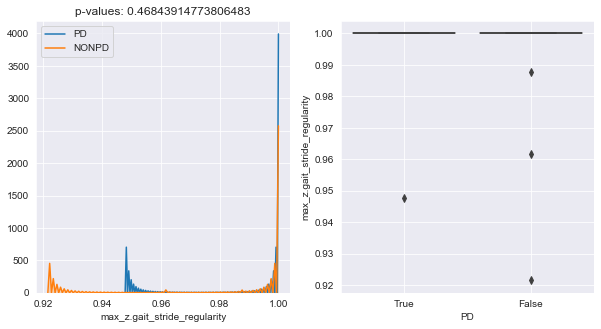

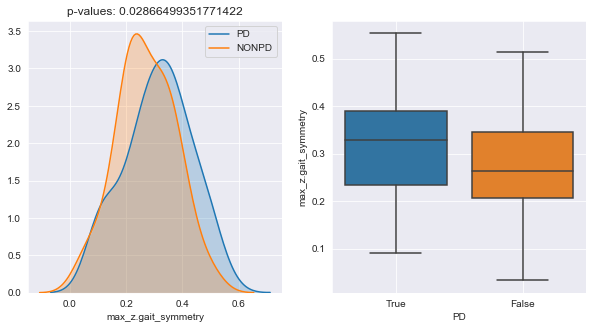

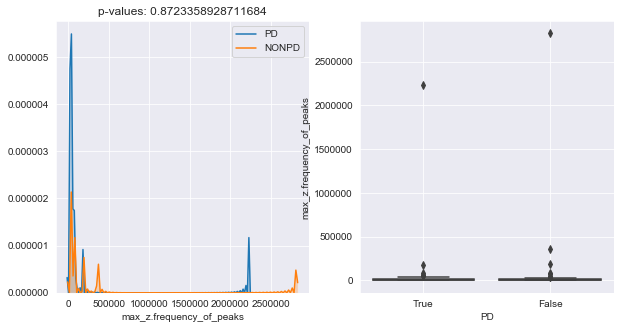

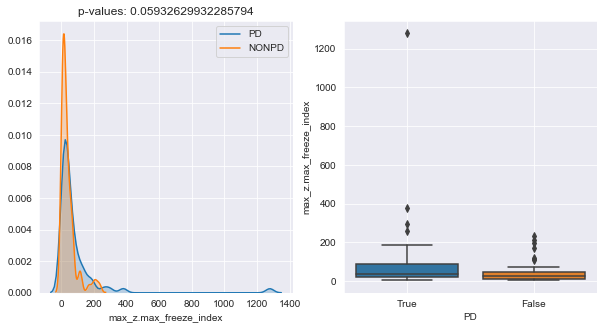

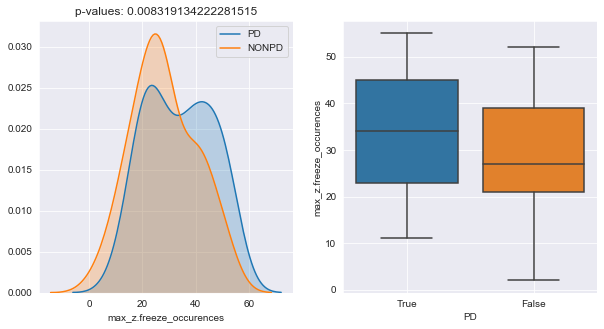

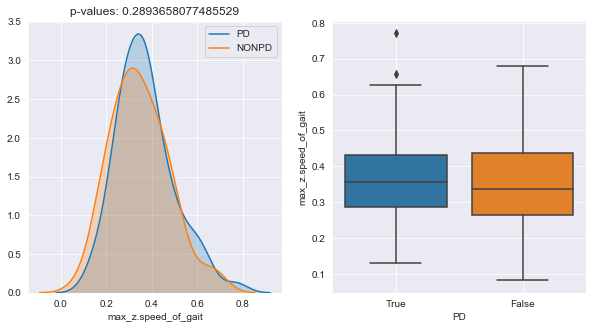

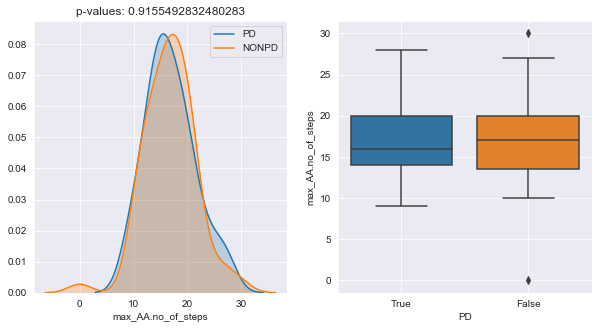

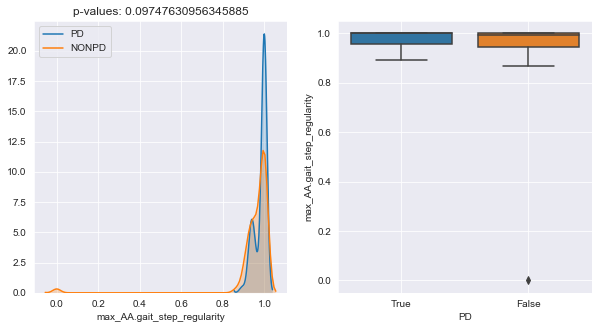

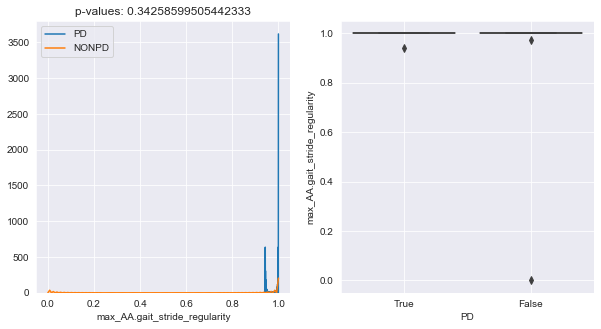

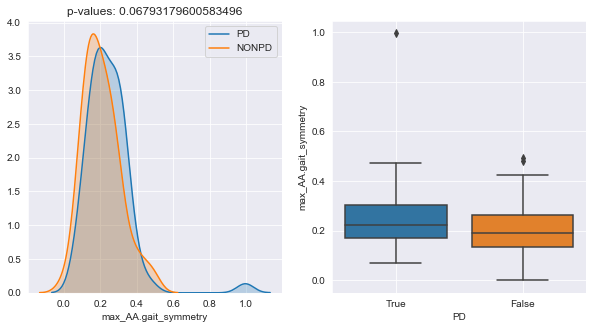

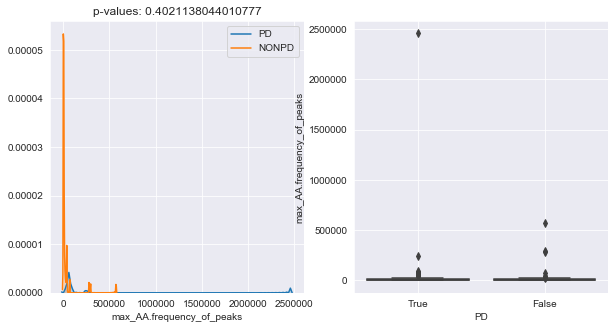

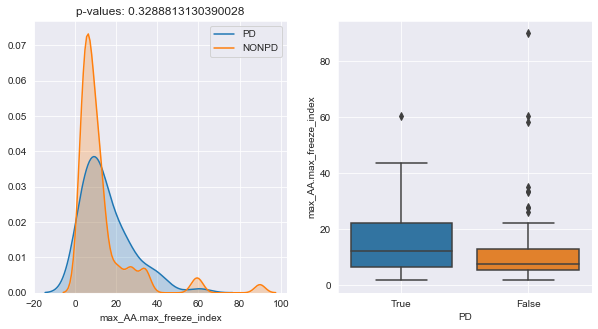

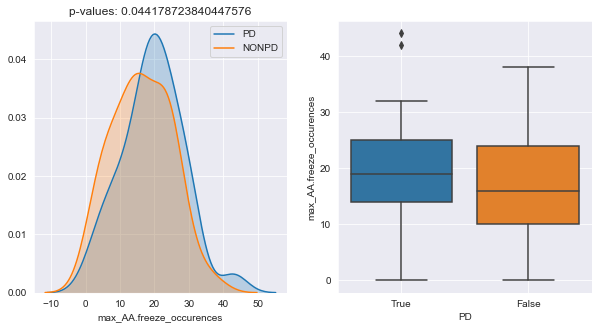

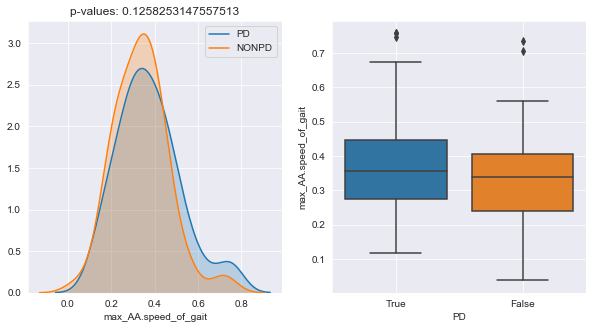

In [22]:
plot_distribution(train)

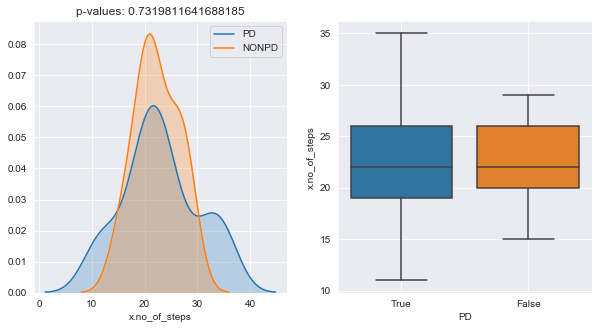

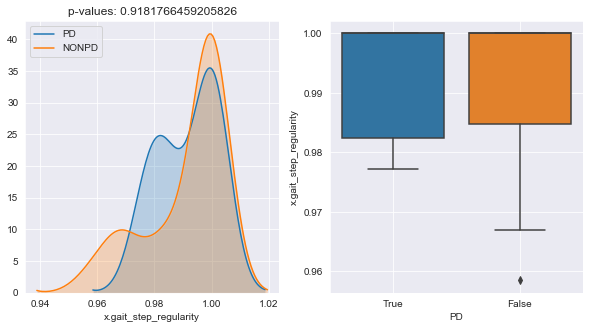

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\scipy\stats\_distn_infrastructure.py:1

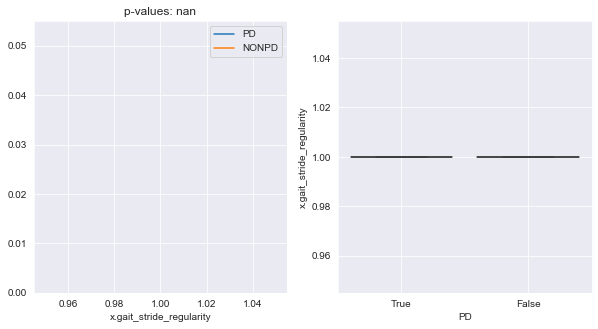

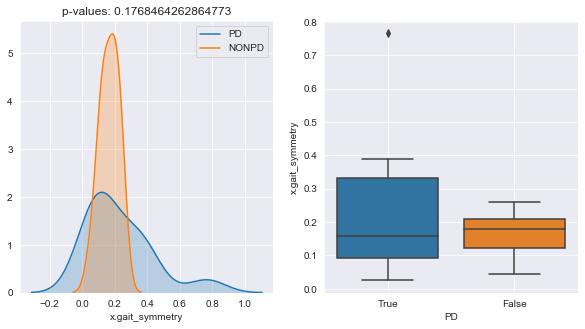

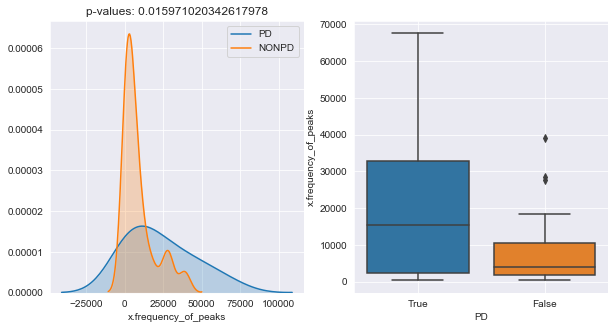

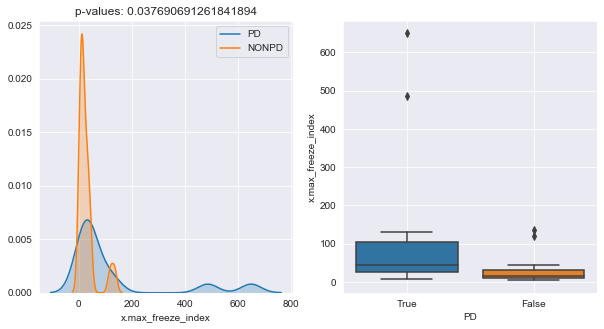

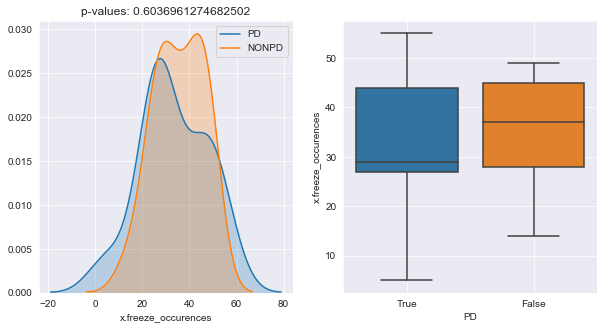

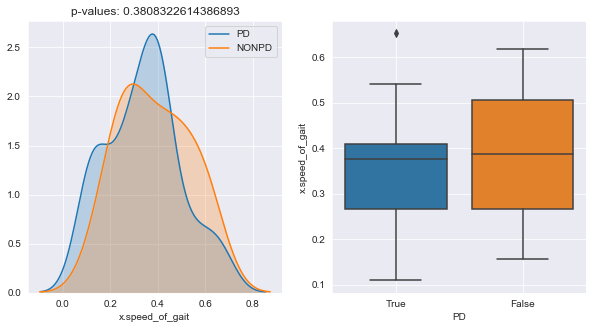

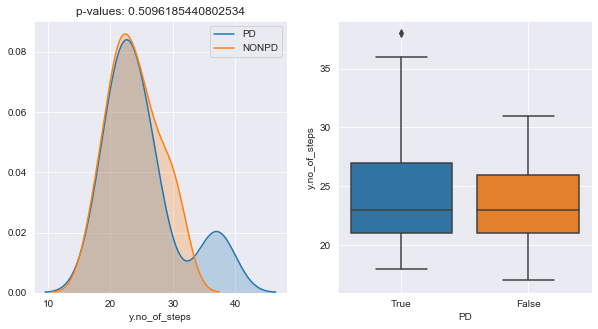

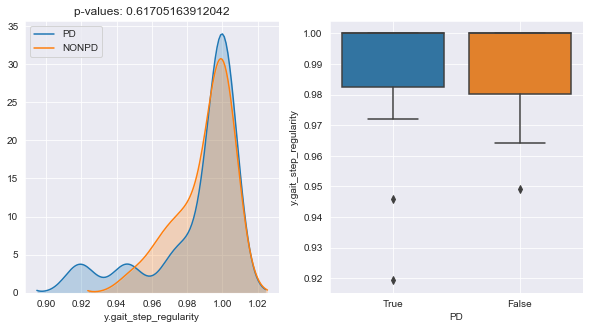

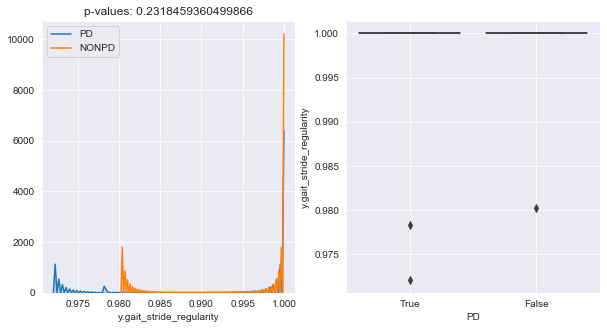

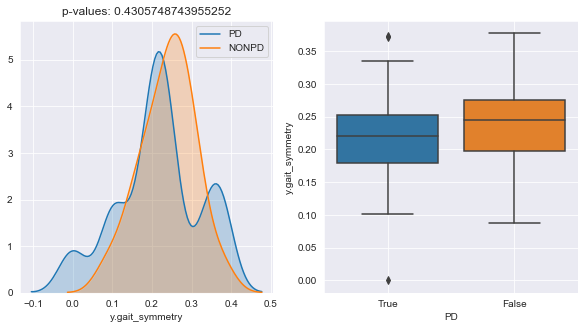

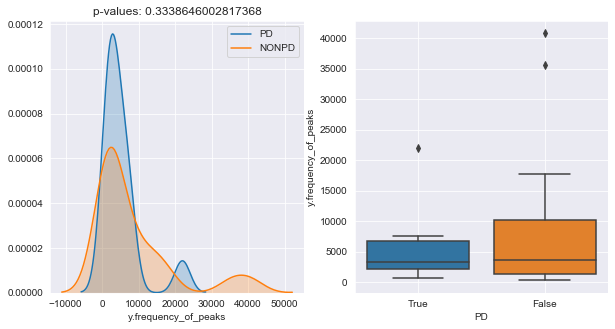

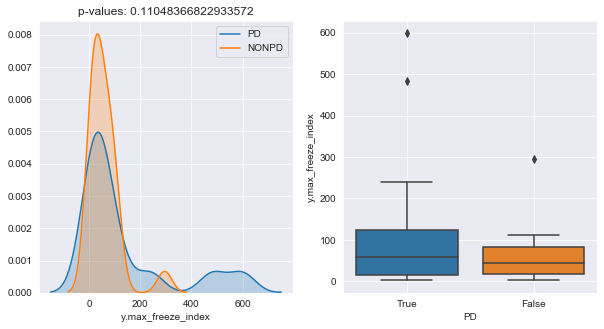

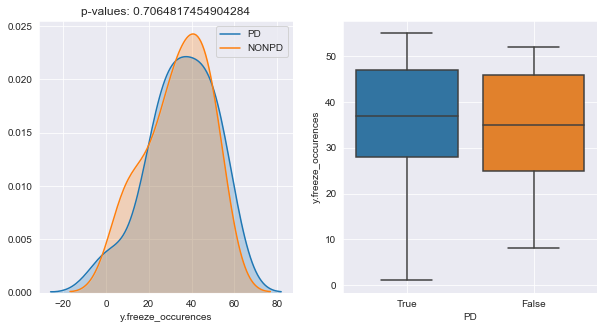

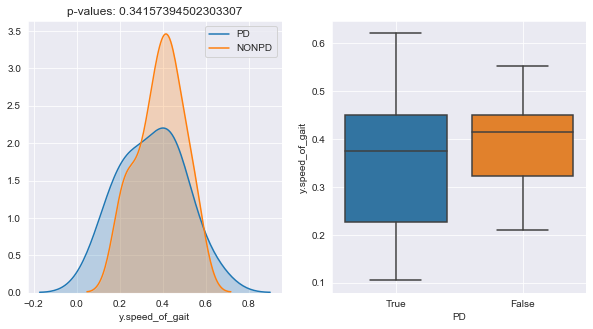

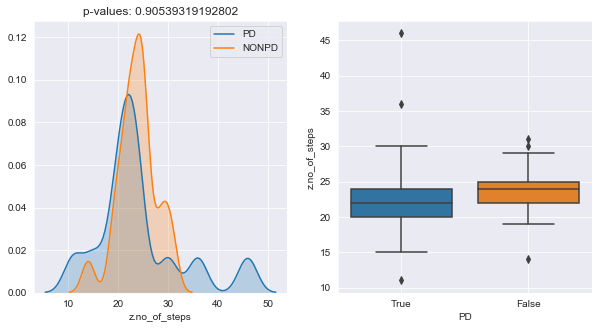

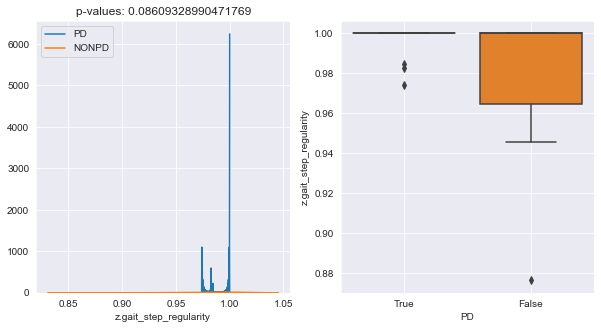

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



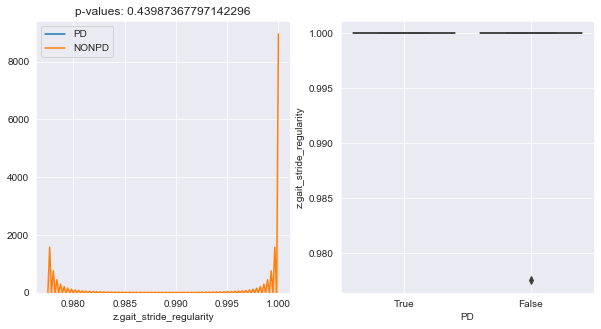

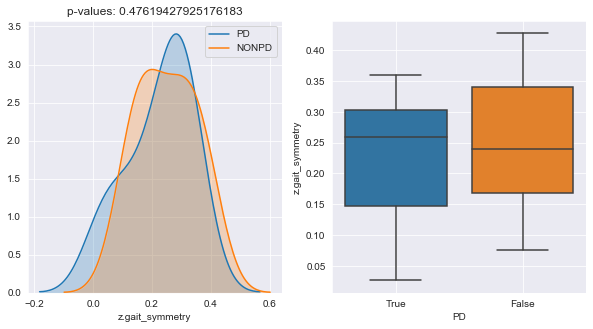

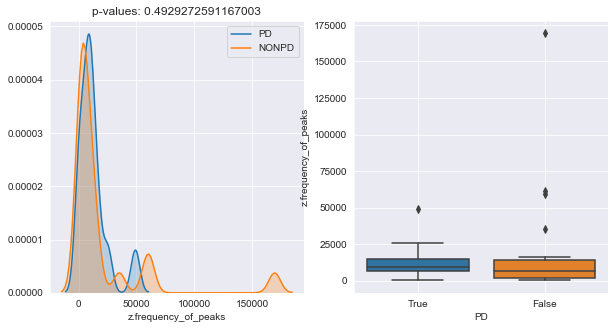

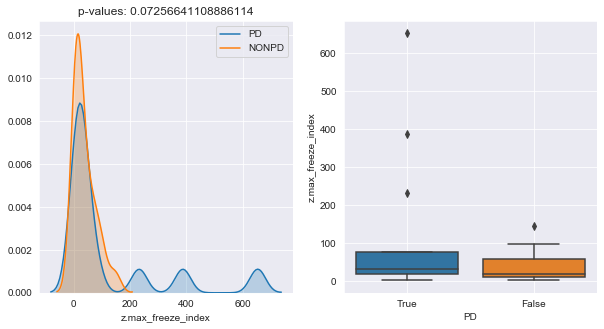

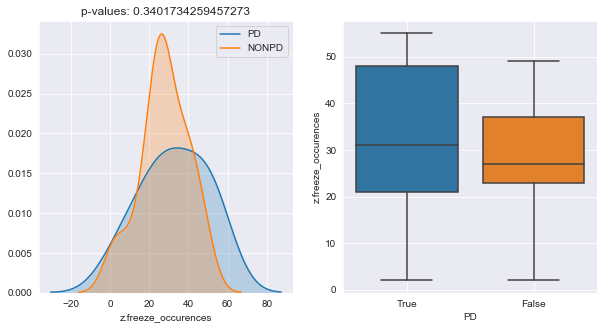

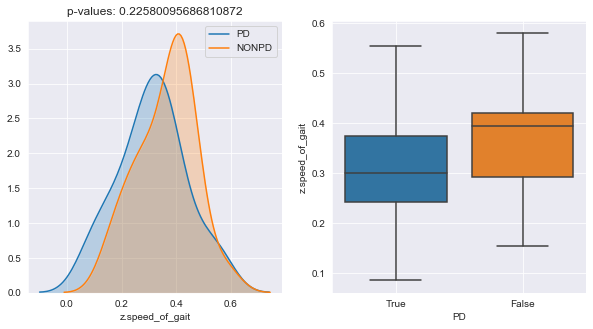

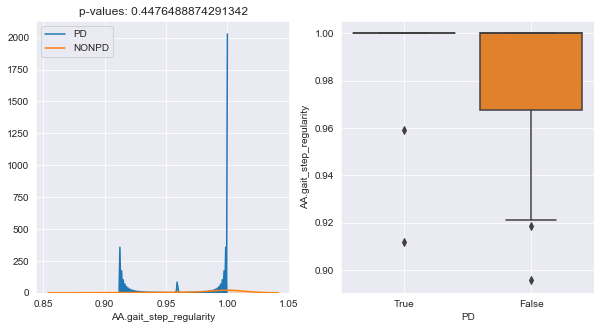

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)

[WARNING] C:\Users\atedi\OneDrive\Documents\SageBionetworks\synapse\lib\site-packages\scipy\stats\_distn_infrastructure.py:1

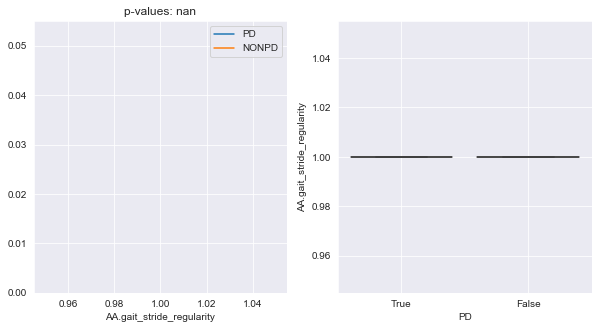

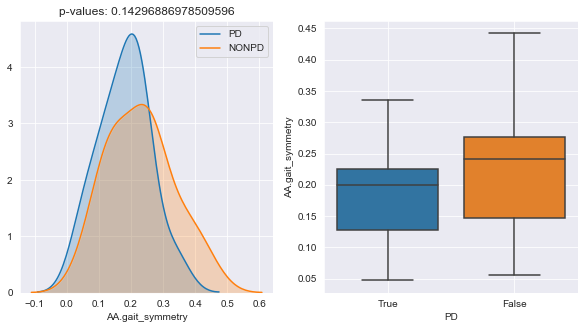

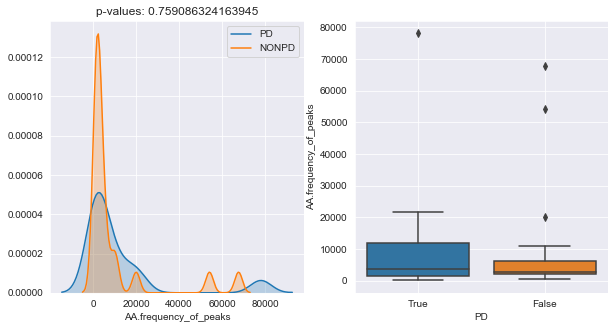

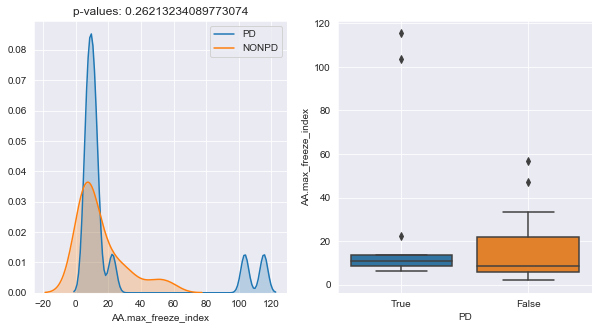

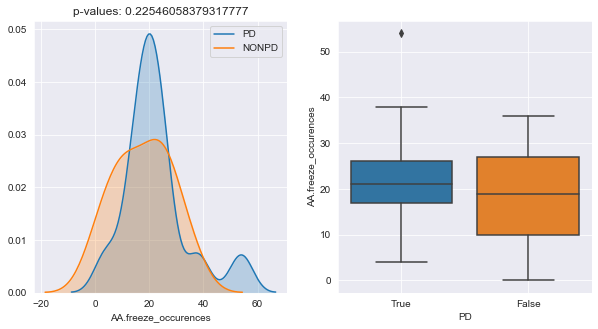

In [88]:
plot_distribution(test)

From the graph above, we can see that frequency of peaks is somewhat an unstable metric on the collapsed max data. This feature will be further assessed with other collapsing methods (mean or median) in the future.

In [23]:
max_data.drop(["recordId","phoneInfo", "createdOn", "gender", "age"], axis = 1).to_csv("../Data/MAX_WALKING_TRAINING_DATA.csv")